In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [6]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

m_data= m_data.groupby('age').mean()
f_data = f_data.groupby('age').mean()

data=pd.concat([m_data,f_data])
#data.set_index('sex',inplace=True,append=True)

In [7]:
#correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman').to_numpy()

In [8]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman')

p_values = m_data.apply(lambda col: spearmanr(col, f_data[col.name])[1]) #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

In [9]:
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)

In [10]:
sorted_result_df['P-Value']*40

12     0.000006
32     0.000013
18     0.000113
20     0.004356
38     0.013563
28     0.022444
26     0.034216
8      0.080377
39     0.081606
0      0.097661
27     0.113033
23     0.137993
11     0.150045
35     0.150045
36     0.262134
3      0.469197
10     0.556615
22     1.936049
1      2.005387
24     2.040779
33     2.742900
14     2.926770
21     3.022172
30     3.701224
37     4.961187
6      7.681150
31     7.728963
15     7.776980
2      8.318717
25    10.095230
13    12.558049
34    23.649992
16    34.471624
4     35.517372
5     34.471624
29    26.007696
9     22.281233
7     17.837976
19     7.078036
17     2.856745
Name: P-Value, dtype: float64

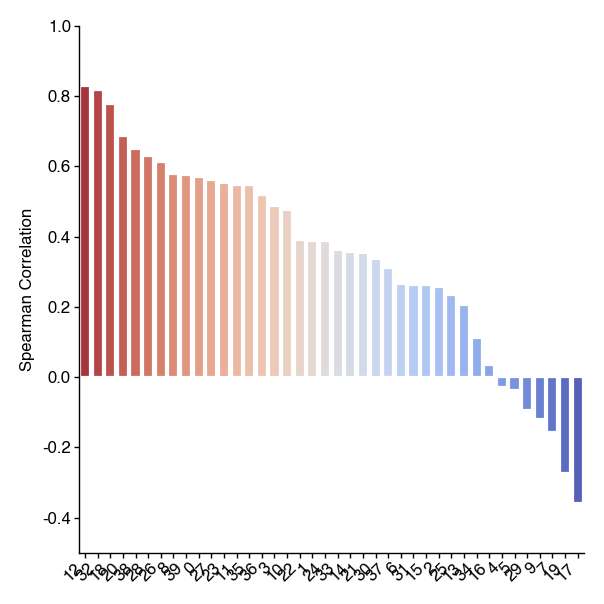

In [11]:
# Create a DataFrame from the correlation values list
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x=list(range(len(sorted_result_df))), y='Correlation', data=sorted_result_df, dodge=True, palette ="coolwarm_r",
           )


plt.xticks(rotation=45, ha='right')
#plt.title('Spearman Correlation between Columns of df1 and df2')
#plt.xlabel('Columns in df1')
plt.ylim([-0.5,1])
plt.ylabel('Spearman Correlation')
ax.set_xticklabels(sorted_result_df.index.values)
plt.tight_layout()
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_crosscorr.pdf')

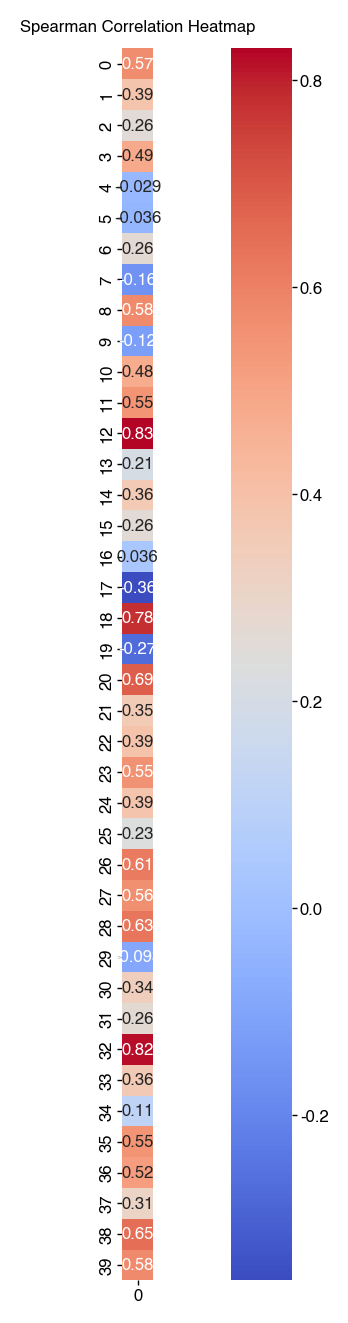

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()

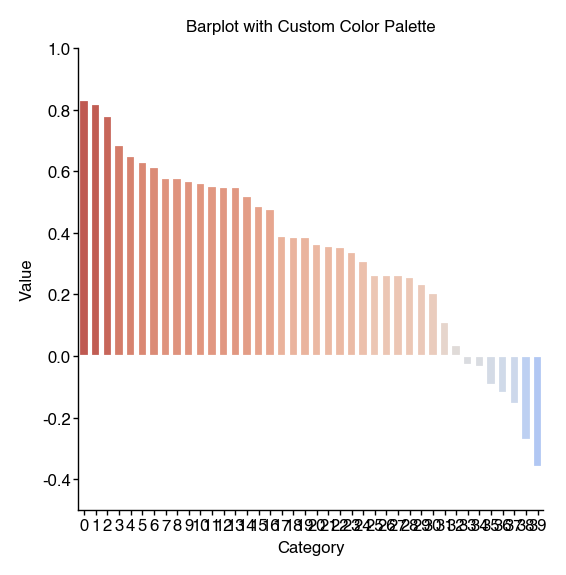

In [16]:
# Create a DataFrame from the correlation values list
from matplotlib.colors import TwoSlopeNorm
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)


df = sorted_result_df.copy()
df['category'] =  -df['Correlation'].rank()
df['value'] = df['Correlation']

# Assume you have your data in a DataFrame called 'df'
# with columns 'category' and 'value'

# Get the minimum and maximum values for normalization
#min_val = df['value'].min()
#max_val = df['value'].max()

min_val = -1
max_val = 1

# Create a TwoSlopeNorm object with the desired center value (0 in this case)
norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)

# Create a colormap object based on 'RdBu_r'
cmap = plt.cm.coolwarm

# Map the normalized values to colors using the colormap
colors = cmap(norm(df['value']))

# Create a custom color palette using the mapped colors
palette = sns.color_palette(colors)

# Create the barplot using Seaborn with the custom color palette
ax = sns.barplot(x=list(range(len(sorted_result_df))), y='value', data=df, palette=palette)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Barplot with Custom Color Palette')
plt.ylim([-0.5,1])
sns.despine()
# Show the plot
plt.show()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_crosscorr_colorchange.pdf')